In [1]:
!python -V

Python 3.7.12


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor

from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error




# Helper Functions

In [4]:
def dataframe_with_dummies(df,dummies,encoder,features):
    """
    function that receives df dataframe with the independent features and does OHE transformation with
    the already fitted encoder "encoder" and returns a dataframe with all of the OHE features, the rest of the features
    of the df dataframe 

    """
    df_dummies = pd.DataFrame(data = encoder.transform(df[dummies]).toarray(),columns = encoder.get_feature_names(dummies))                        
    print('shape dummiesdf:',df_dummies.shape)
    df = pd.concat([df[features], df_dummies], axis=1)
    print('shape after merge:',df.shape)

    df.columns = features + list(encoder.get_feature_names(dummies))
    return df    

def plot_feature_importance(importance,names,model_type,num_features):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df.iloc[:num_features,:num_features]
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.show()
    return list(fi_df['feature_names'])

# Load Data

In [5]:
TRAIN_FILE = 'train.csv.zip'
TEST_FILE = 'test.csv.zip'
SAMPLE_PREDICTION = 'sampleSubmission.csv.zip'

train = pd.read_csv(TRAIN_FILE)
test = pd.read_csv(TEST_FILE)


sample_prediction = pd.read_csv(SAMPLE_PREDICTION)


pd.set_option('max_columns',None)
train.drop(columns=['Id'],inplace=True)
test.drop(columns=['Id'],inplace=True)



In [6]:
initial_features = list(train.columns)

# Data fields
- Id : Restaurant id. 
- Open Date : opening date for a restaurant
- City : City that the restaurant is in. Note that there are unicode in the names. 
- City Group: Type of the city. Big cities, or Other.
- Type: Type of the restaurant. FC: Food Court, IL: Inline, DT: Drive Thru, MB: Mobile
- P1, P2 - P37: There are three categories of these obfuscated data. Demographic data are gathered from third party providers with GIS systems. These include population in any given area, age and gender distribution, development scales. Real estate data mainly relate to the m2 of the location, front facade of the location, car park availability. Commercial data mainly include the existence of points of interest including schools, banks, other QSR operators.
- Revenue: The revenue column indicates a (transformed) revenue of the restaurant in a given year and is the target of predictive analysis. Please note that the values are transformed so they don't mean real dollar values. 

# Exploring the data

In [7]:
train.head()

,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,5,4,5,5,3,5,5.0,1,2,2,2,4,5,4,1,3,3,1,1,1.0,4.0,2.0,3.0,5,3,4,5,5,4,3,4,5653753.0
1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,2,5,5,5,5,1,5,5.0,0,0,0,0,0,3,2,1,3,2,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,6923131.0
2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,3,5,5,5,5,2,5,5.0,0,0,0,0,0,1,1,1,1,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0,2055379.0
3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,4,10,8,10,10,8,10,7.5,6,4,9,3,12,20,12,6,1,10,2,2,2.5,2.5,2.5,7.5,25,12,10,6,18,12,12,6,2675511.0
4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,2,5,5,5,5,2,5,5.0,2,1,2,1,4,2,2,1,2,1,2,3,3.0,5.0,1.0,3.0,5,1,3,2,3,4,3,3,4316715.0


## Initial Comments  
- We see that P1-P37 are all numerical and we don't have information about what is each one of those (we only have  
general information about all of them).  
- From Open Date we could extract 2 different features. 
    1. The year of the opening (because it could be that the market changed and that new restaurants have a harder time  
    getting to be popular and generate revenue and older ones could be more popular (or some other phenomena).
    2. years_passed that means how many years have passed since the opening. This could make sense because the oldest the  
    restuarant is could mean it is well stablished and get's some important revenue.  
- City, City Group and Type are nominal features. Before doing OHE we'll see if they need some previous manipulation.

## Correlation

We can see that none of the P features have a very high correlation with the revenue.

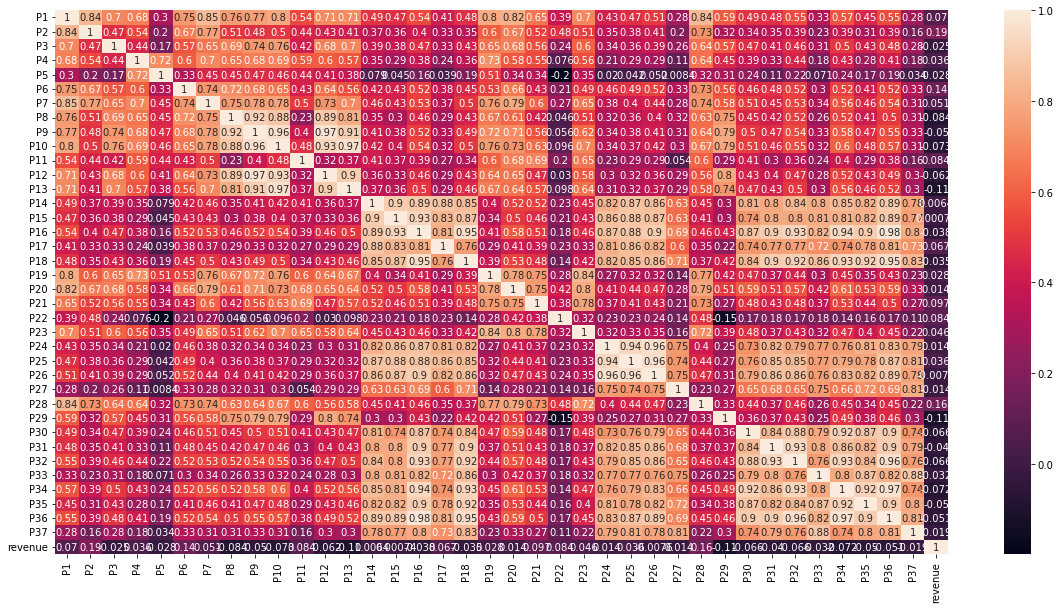

In [8]:
plt.figure(figsize = (20, 10))
sns.heatmap(train.corr(), annot = True);

## Open Date feature  
We'll create years_passed feature, as explained before and also we'll extract the year, month and day of the opening.  
We'll use es the present day, the NOW , as the date of the last opening of the restaurants.

In [9]:
NOW =pd.Timestamp('2014-01-25')
seconds_in_year = 3600*34*365

for df in [train,test]:
    df.loc[:,'year'] = df['Open Date'].apply(lambda s: int(s[6:]))
    df['day'] = df['Open Date'].apply(lambda s: int(s[3:5]))
    df['month'] = df['Open Date'].apply(lambda s: int(s[:2]))
    df['Open Date'] = pd.to_datetime(df['Open Date']) 
    df.loc[:,'years_passed'] = df['Open Date'].apply(lambda x:(NOW - pd.Timestamp(x)).total_seconds()/(seconds_in_year))
    df.drop(columns=['Open Date'],inplace=True)

In [10]:
new_features = ['year','day','month','years_passed']

## Nominal features.

C:\Users\Daniel\Anaconda3\envs\general\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


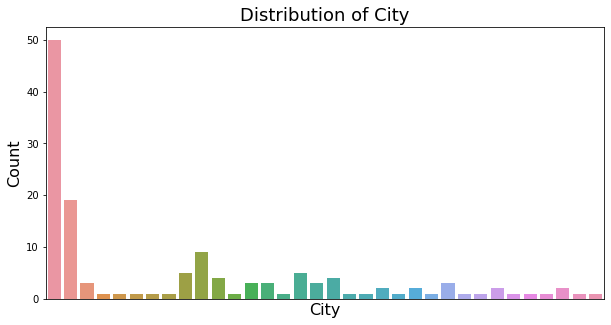

In [11]:
#checking the distribution of some features.
plt.figure(figsize=(10,5))
sns.countplot(train.City)
plt.xlabel('City',size=16)
plt.ylabel('Count',size=16)
plt.title('Distribution of City', size = 18)
plt.xticks([])
plt.show()

We see that there's a lot of data from one city and little of the rest.    
We'll check value counts of the cities that have more than one data point

In [12]:
train.City.value_counts()[train.City.value_counts()>=2]

İstanbul      50
Ankara        19
İzmir          9
Bursa          5
Samsun         5
Sakarya        4
Antalya        4
Kayseri        3
Eskişehir      3
Adana          3
Diyarbakır     3
Tekirdağ       3
Muğla          2
Trabzon        2
Aydın          2
Konya          2
Name: City, dtype: int64

It makes sense that the model wont learn with so little data to differenciate between different cities.   
Unless used in some aggregation, this feature shoul be changed to a feature with less categories.
I'll take the cities with data >= 5 % as a mormal theshold, and the rest will be a new category 'Other'.

In [13]:
my_cities = list(train.City.value_counts()[train.City.value_counts() >= train.shape[0]*0.05].index)

for df in [train,test]:
    df.loc[:,'City'] =  df.City.apply(lambda s: s if s in my_cities else 'Other')

With these new categories, we'll check the revenue distribution per city.

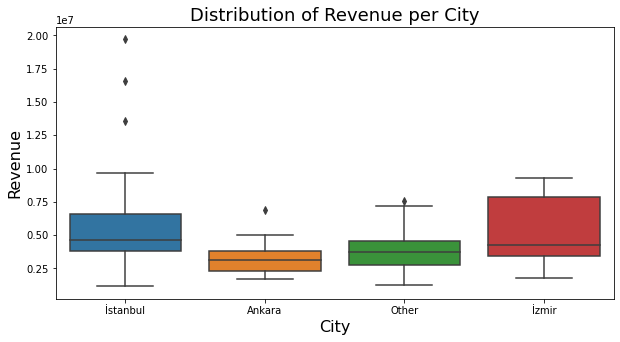

In [14]:
plt.figure(figsize=(10,5))

sns.boxplot(x="City", y="revenue", data=train)
plt.xlabel('City',size=16)
plt.ylabel('Revenue',size=16)
plt.title('Distribution of Revenue per City', size = 18)
plt.show()

We can see that Istanbul and Izmir have a distribution that's higher than the rest of the cities.  
We also see some outliers. We'll deal with those later on.

C:\Users\Daniel\Anaconda3\envs\general\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


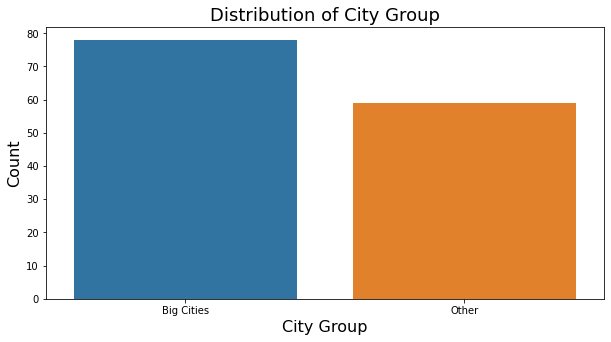

In [15]:

#checking the distribution of some features.
#CITY GROUP

plt.figure(figsize=(10,5))
sns.countplot(train['City Group'])
plt.xlabel('City Group',size=16)
plt.ylabel('Count',size=16)
plt.title('Distribution of City Group', size = 18)
plt.show()



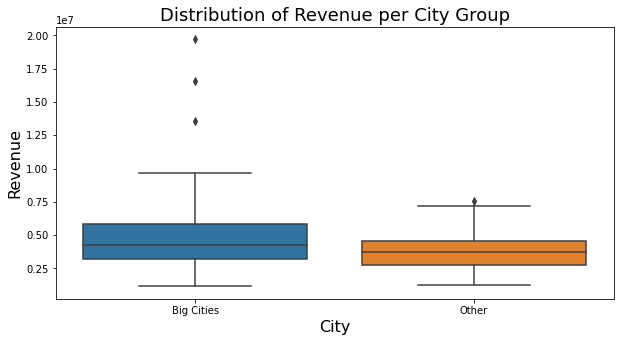

In [16]:
plt.figure(figsize=(10,5))

sns.boxplot(x="City Group", y="revenue", data=train)
plt.xlabel('City',size=16)
plt.ylabel('Revenue',size=16)
plt.title('Distribution of Revenue per City Group', size = 18)
plt.show()

As expected the revenue is higher in Big Cities.  
Also, as we see in the snippet below, these big cities include the cities we showed above.

In [17]:
cities_in_bc = train[train['City Group']=='Big Cities']['City'].unique()
print(f'The cities included in Big Cities are : {cities_in_bc}')

The cities included in Big Cities are : ['İstanbul' 'Ankara' 'İzmir']


C:\Users\Daniel\Anaconda3\envs\general\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


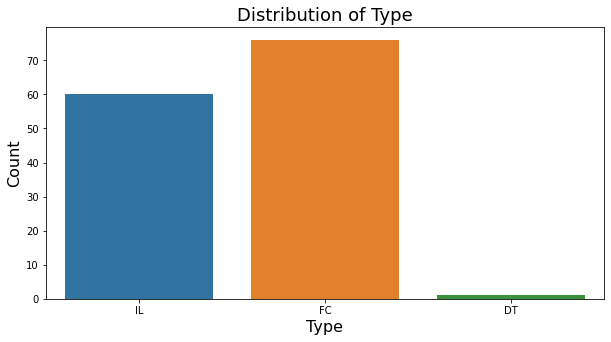

In [18]:
#Type
#checking the distribution of some features.
plt.figure(figsize=(10,5))
sns.countplot(train['Type'])
plt.xlabel('Type',size=16)
plt.ylabel('Count',size=16)
plt.title('Distribution of Type', size = 18)
plt.show()


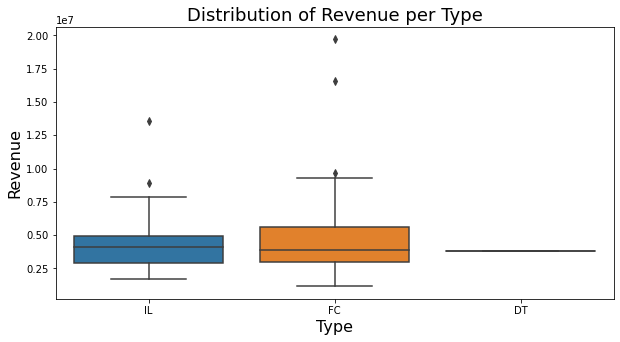

In [19]:
#check revenue per Type
plt.figure(figsize=(10,5))

sns.boxplot(x="Type", y="revenue", data=train)
plt.xlabel('Type',size=16)
plt.ylabel('Revenue',size=16)
plt.title('Distribution of Revenue per Type', size = 18)
plt.show()

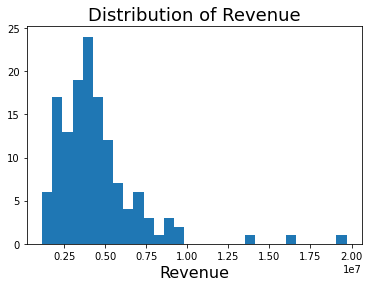

In [20]:
plt.hist(train.revenue, bins=30)
plt.xlabel('Revenue',size=16)
plt.title('Distribution of Revenue', size = 18)

plt.show()

We can clearly see that the distribution is skewed and that it presents some potential outliers.

In [21]:
revenue_mean = train.revenue.mean()
revenue_std =  train.revenue.std()
print(f'We have {train.shape[0]} rows in our train set')
print(f'Taking the rows outside 3 times the std we have {int(train[train.revenue <= revenue_mean +revenue_std*3].shape[0])} rows')

We have 137 rows in our train set
Taking the rows outside 3 times the std we have 134 rows


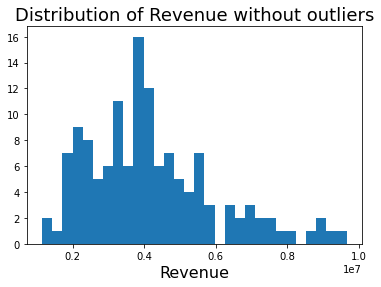

In [22]:
plt.hist(train[train.revenue <= revenue_mean +revenue_std*3].revenue, bins=30)
plt.xlabel('Revenue',size=16)
plt.title('Distribution of Revenue without outliers', size = 18)

plt.show()

In [23]:
#we'll just drop those rows because they could affect our model's performance and they are only 3 rows.
train = train[train.revenue <= revenue_mean +revenue_std*3]


# Missing Values

In [24]:
# no null values in train set
train.isna().sum()[train.isna().sum()>0]

Series([], dtype: int64)

In [25]:
#no null values in test set 
test.isna().sum()[test.isna().sum()>0]

Series([], dtype: int64)

## OHE

In [26]:
#have to separate train set because test set doesn't have
train.reset_index(drop=True,inplace=True)
X_train = train.loc[:,train.columns!='revenue']
y_train = train.revenue
#define variable to do onehotencoder  
ohe_features = ['City','City Group','Type']
rest_features = list(set(X_train.columns) - set(ohe_features))

X_train = X_train[ohe_features + rest_features]
test = test[ohe_features + rest_features]
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_train[ohe_features])
X_train =  dataframe_with_dummies(X_train,ohe_features,enc,rest_features)

test =  dataframe_with_dummies(test,ohe_features,enc,rest_features)

shape dummiesdf: (134, 9)
shape after merge: (134, 50)
shape dummiesdf: (100000, 9)
shape after merge: (100000, 50)


# Modeling  
Now we are ready to start doing some models with the data.  
First we'll do a model with the best features (we'll use RandomForest in order to get the 10 best features and we'll show them). Since this data comes from Kaggle Dataset and they didn't provide the actual y_test, we can only messure the outcome in the  
train set and for sure that there could be overfitting. We'll just do as we would in a normal case.


In [27]:
# simple_rf.feature_importances_

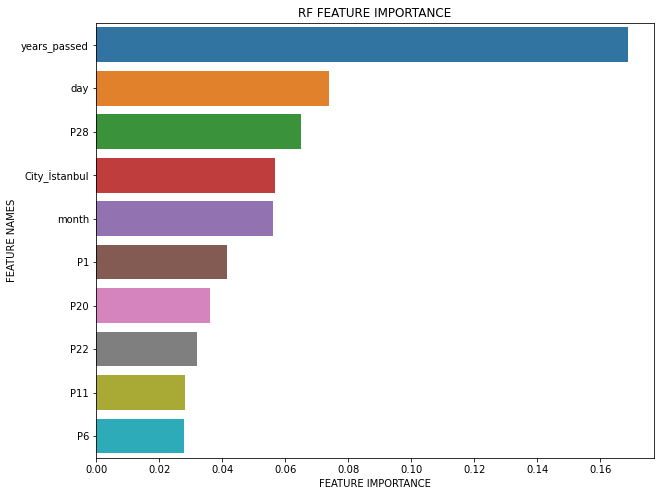

In [28]:
#Baseline model 
simple_rf = RandomForestRegressor()
simple_rf.fit(X_train,y_train)
best_10_features = plot_feature_importance(simple_rf.feature_importances_,X_train.columns,'RF',10)


**RIDGE MODEL with 10 best features**

In [29]:
ridge = Ridge()
ridge.fit(X_train[best_10_features],y_train)
y_preds = ridge.predict(X_train[best_10_features])
R2 = r2_score(y_train,y_preds)
MSE = mean_squared_error(y_train,y_preds)
MAE = mean_absolute_error(y_train,y_preds)
MAPE = mean_absolute_percentage_error(y_train,y_preds)
print('R^2: ',R2)
print('MSE: ',MSE)
print('MAE: ',MAE)
print('MAPE: ',MAPE)

R^2:  0.16529608291864506
MSE:  2683052355210.625
MAE:  1286306.5463172833
MAPE:  0.3742628881786429


**RIDGE MODEL with all features**

In [30]:
ridge = Ridge()
ridge.fit(X_train,y_train)
y_preds = ridge.predict(X_train)
R2 = r2_score(y_train,y_preds)
MSE = mean_squared_error(y_train,y_preds)
MAE = mean_absolute_error(y_train,y_preds)
MAPE = mean_absolute_percentage_error(y_train,y_preds)
print('R^2: ',R2)
print('MSE: ',MSE)
print('MAE: ',MAE)
print('MAPE: ',MAPE)

R^2:  0.45645213090311576
MSE:  1747167301489.938
MAE:  1052861.8202377148
MAPE:  0.3087922691315907


We see how it clearly improved with all of the features.

In [31]:
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
y_preds = rf.predict(X_train)
R2 = r2_score(y_train,y_preds)
MSE = mean_squared_error(y_train,y_preds)
MAE = mean_absolute_error(y_train,y_preds)
MAPE = mean_absolute_percentage_error(y_train,y_preds)
print('R^2: ',R2)
print('MSE: ',MSE)
print('MAE: ',MAE)
print('MAPE: ',MAPE)

R^2:  0.8792699425687335
MSE:  388071816013.89575
MAE:  468270.079477612
MAPE:  0.13317845576707532


We see how it clearly improved with the RandomForest

In [33]:
cb = CatBoostRegressor(verbose=False)
cb.fit(X_train,y_train)
y_preds = cb.predict(X_train)
R2 = r2_score(y_train,y_preds)
MSE = mean_squared_error(y_train,y_preds)
MAE = mean_absolute_error(y_train,y_preds)
MAPE = mean_absolute_percentage_error(y_train,y_preds)
print('R^2: ',R2)
print('MSE: ',MSE)
print('MAE: ',MAE)
print('MAPE: ',MAPE)

R^2:  0.9992187320532397
MSE:  2511289047.181282
MAE:  39499.96927506263
MAPE:  0.011816109876389848


Here we see a R2 of .99 with Catboost. Since we are not using a validation or test set is hard to see which model is better  
because of overtiffing

In [35]:
xgb = XGBRegressor(n_estimators=1000)
xgb.fit(X_train,y_train)
y_preds = xgb.predict(X_train)
R2 = r2_score(y_train,y_preds)
MSE = mean_squared_error(y_train,y_preds)
MAE = mean_absolute_error(y_train,y_preds)
MAPE = mean_absolute_percentage_error(y_train,y_preds)
print('R^2: ',R2)
print('MSE: ',MSE)
print('MAE: ',MAE)
print('MAPE: ',MAPE)

R^2:  0.999999999999877
MSE:  0.39540578358208955
MAE:  0.439365671641791
MAPE:  1.1695800922313908e-07


At least on the train set alone, XGBoost got the best results by far.

In [38]:
sample_prediction.Prediction = xgb.predict(test)

In [40]:
sample_prediction.head()

,Id,Prediction
0,0,3787454.50
1,1,3000318.25
2,2,3558370.50
3,3,3871853.50
4,4,4932657.00


In [41]:
sample_prediction.to_csv('sub.csv',index=False)


Once i uploaded the file to kaggle (even though this is an old competition) i got a RMSE of 1852238.34349 which would  
put me around place 850.